In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gzip,pickle
import mytorch
import myai
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [3]:
tr,va,te=pickle.load(gzip.open('data/mnist.pkl.gz'),encoding='latin1')

In [4]:
def normalize(x,mean,std): return (x-mean)/std
tr_mean,tr_std=tr[0].mean(),tr[0].std()
def denorm(x): return x*tr_std+tr_mean
tr[0].min(),tr[0].max(),tr_mean,tr_std

(0.0, 0.99609375, 0.13044983, 0.3072898)

In [5]:
tr=(normalize(tr[0],tr_mean,tr_std),tr[1])
va=(normalize(va[0],tr_mean,tr_std),va[1])
te=(normalize(te[0],tr_mean,tr_std),te[1])
tr[0].mean(),tr[0].std(),va[0].mean(),va[0].std(),te[0].mean(),te[0].std()

(-3.1638146e-07, 0.99999934, -0.005850922, 0.99243325, 0.005034822, 1.0064359)

In [6]:
denorm(tr[0]).min(),denorm(tr[0]).max(),tr[0].min(),tr[0].max()

(0.0, 0.99609375, -0.42451727, 2.8170278)

In [7]:
n_in=te[0].shape[1]
n_out=te[1].max()+1
n_in,n_out

(784, 10)

In [8]:
class Resize(mytorch.Module):
    def forward(self,x): return x.reshape((-1,1,28,28))
class Flatten(mytorch.Module):
    def forward(self,x): return x.reshape((len(x),-1))

def getm():
    return mytorch.Seq(
        Resize() # 784 -> 1x28x28
        ,mytorch.Conv2d(1,8,5,padding=2,stride=2),mytorch.ReLU() #14
        ,mytorch.Conv2d(8,16,3,padding=1,stride=2),mytorch.ReLU() #7
        ,mytorch.Conv2d(16,32,3,padding=1,stride=2),mytorch.ReLU() #4
        ,Flatten()
        ,mytorch.Linear(32*4*4,n_out)
    )

In [9]:
dev='cpu'
if mytorch.cuda_is_available(): dev='cuda'
dev

'cuda'

In [10]:
class TimeCallback:
    def before_fit(self): self.t0=time()
    def after_fit(self): print('total time %.2fs' % (time()-self.t0,))
        
class StatsCallback:
    def __init__(self):
        self.tr_losses,self.val_losses,self.accs=[],[],[]
    def before_epoch(self):
        self.tr_loss,self.val_loss,self.acc=0,0,0
        self.tr_cnt,self.val_cnt=0,0
    def after_loss(self):
        cnt=len(self.learn.xb)
        if self.learn.training:
            self.tr_loss+=self.learn.loss.detach()*cnt
            self.tr_cnt+=cnt
        else:
            self.acc+=(self.learn.preds.argmax(axis=1)==self.learn.yb).sum()
            self.val_loss+=self.learn.loss*cnt
            self.val_cnt+=cnt
    def after_epoch(self):
        self.tr_losses.append(self.tr_loss.item()/self.tr_cnt)
        self.val_losses.append(self.val_loss.item()/self.val_cnt)
        self.accs.append(self.acc.item()/self.val_cnt)
        print('%3d. train loss %.4f | valid loss %.4f | accuracy %.4f' %
              (self.learn.epoch,self.tr_losses[-1],self.val_losses[-1],self.accs[-1]))

In [139]:
batch_size=100
lr=.1

def getdl(x,y,shuffle=False,first_n=None):
    if first_n: x,y=x[:first_n],y[:first_n]
    x,y=map(lambda x:mytorch.tensor(x,device=dev),[x,y])
    ds=mytorch.TensorDataset(x,y)
    return mytorch.DataLoader(ds,bs=batch_size,shuffle=shuffle)

trdl=getdl(*tr,shuffle=True)
valdl=getdl(*va)
m=getm().to(dtype=mytorch.float32,device=dev)
opt=mytorch.SGD(m.params(),lr,set_to_none=True)
stats=StatsCallback()
lrn=myai.Learner(trdl,m,opt,mytorch.cross_entropy,valdl=valdl,
            cbs=[TimeCallback(),stats])

In [140]:
mod2idx={}
fstats,bstats={},{}

def fhook(m,inp,out):
    out=out.detach()
    st=fstats[mod2idx[m]]
    st['mean'].append(out.mean())
    st['std'].append(out.std())
    st['hist'].append(out.histc(80,-20,20))

def bhook(m,gin,gout):
    st=bstats[mod2idx[m]]
    st['w'].append(gout[1].abs().sum())
    st['b'].append(gout[2].abs().sum())

for i,mod in enumerate(m):
    if isinstance(mod,(mytorch.Conv2d,mytorch.Linear)):
        mod.add_forward_hook(fhook)
        fstats[i]={'mean':[],'std':[],'hist':[]}
        mod.add_backward_hook(bhook)
        bstats[i]={'b':[],'w':[]}
        mod2idx[mod]=i

In [141]:
lrn.fit(10)

  0. train loss 0.3038 | valid loss 0.1141 | accuracy 0.9675
  1. train loss 0.1066 | valid loss 0.0901 | accuracy 0.9754
  2. train loss 0.0765 | valid loss 0.0782 | accuracy 0.9783
  3. train loss 0.0636 | valid loss 0.0794 | accuracy 0.9781
  4. train loss 0.0541 | valid loss 0.0643 | accuracy 0.9827
  5. train loss 0.0460 | valid loss 0.0712 | accuracy 0.9822
  6. train loss 0.0402 | valid loss 0.0682 | accuracy 0.9827
  7. train loss 0.0368 | valid loss 0.0619 | accuracy 0.9842
  8. train loss 0.0328 | valid loss 0.0668 | accuracy 0.9836
  9. train loss 0.0294 | valid loss 0.0607 | accuracy 0.9861
total time 77.08s


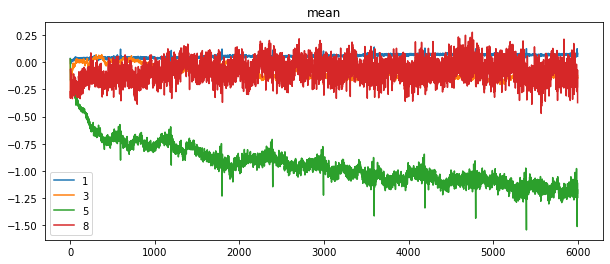

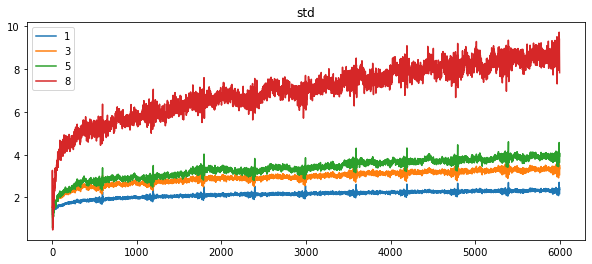

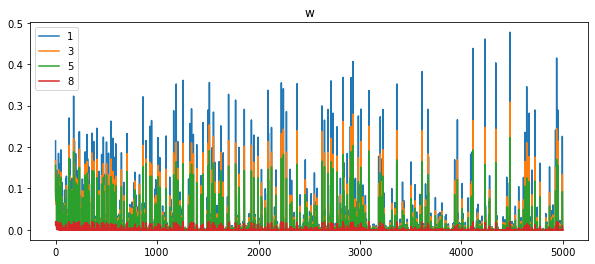

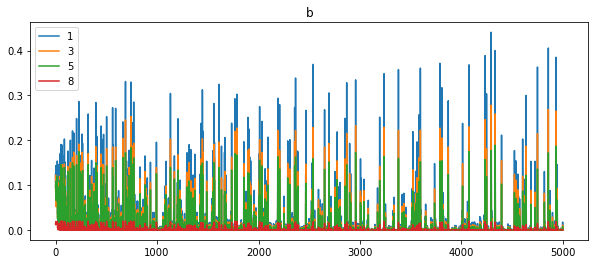

In [142]:
def plotlstat(stats,name):
    plt.figure(figsize=(10,4))
    plt.title(name)
    for l,vals in stats.items():
        plt.plot(mytorch.tensor(vals[name]).cpu(),label=l)
    plt.legend()
    plt.show()
plotlstat(fstats,'mean')
plotlstat(fstats,'std')
plotlstat(bstats,'w')
plotlstat(bstats,'b')

In [143]:
plt.figure(figsize=(13,8))
plt.title('histogram')
for i,(l,vals) in enumerate(fstats.items()):
    hist=mytorch.tensor(vals['hist']).T.float().log1p().cpu()
    ax=plt.subplot(len(fstats),1,i+1)
    ax.set_title(l,loc='right')
    ax.imshow(hist,origin='lower',aspect='auto')

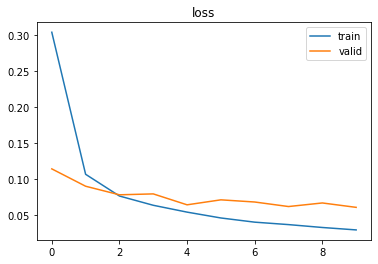

In [144]:
plt.title('loss')
plt.plot(stats.tr_losses,label='train')
plt.plot(stats.val_losses,label='valid')
plt.legend()
plt.show()
plt.title('accuracy')
plt.plot(stats.accs)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset

In [41]:
class Resize(nn.Module):
    def forward(self,x): return x.reshape((-1,1,28,28))
class Flatten(nn.Module):
    def forward(self,x): return x.reshape((len(x),-1))
def getm():
    return nn.Sequential(
        Resize() # 784 -> 1x28x28
        ,nn.Conv2d(1,8,5,padding=2,stride=2),nn.ReLU() #14
        ,nn.Conv2d(8,16,3,padding=1,stride=2),nn.ReLU() #7
        ,nn.Conv2d(16,32,3,padding=1,stride=2),nn.ReLU() #4
        ,Flatten()
        ,nn.Linear(32*4*4,n_out)
    )

def getdl(x,y,shuffle=False,first_n=None):
    if first_n: x,y=x[:first_n],y[:first_n]
    x,y=map(lambda x:torch.tensor(x,device=dev),[x,y])
    ds=TensorDataset(x,y)
    return DataLoader(ds,batch_size=batch_size,shuffle=shuffle)

trdl=getdl(*tr,shuffle=True)
valdl=getdl(*va)
m=getm().to(device=dev)
opt=optim.SGD(m.parameters(),lr)
t0=time()
for ep in range(n_ep):
    totloss=0.
    for xb,yb in trdl:
        loss=F.cross_entropy(m(xb),yb)
        totloss+=loss.item()*len(xb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print('train loss',totloss/len(tr[0]))

    with torch.no_grad():
        loss=0.
        acc=0.
        for xb,yb in valdl:
            yhat=m(xb)
            acc+=(yhat.argmax(axis=1)==yb).sum().item()
            loss+=F.cross_entropy(yhat,yb).item()*len(xb)
        print(acc/len(va[0]),loss/len(va[0]))
print(time()-t0,'s')

train loss 0.5143283933699131
0.9621 0.1388060618750751
train loss 0.12304508703574538
0.9679 0.11211160973645747
train loss 0.0891373685207218
0.978 0.07642323927721009
9.099228382110596 s
